In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

import seaborn as sns

import time
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error

c:\Users\sjy99\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv('data/dataset_collaboration_with_survey_scores.csv')

dataset.loc[:, 'num_speakers'] = dataset.groupby(['project', 'meeting_number'])[
    'speaker_id'].transform('nunique')
dataset = dataset[dataset['speaker_id'] == dataset['next_speaker_id']].copy()
# Ensure interaction_count column exists
dataset['interaction_count'] = dataset['count']

if 'interaction_count' not in dataset.columns:
    dataset['interaction_count'] = 0

dataset.loc[:, 'normalized_interaction_frequency'] = dataset['interaction_count'] / \
    dataset['duration']

# Filter the data for project 4
dataset_project_4 = dataset[
    (dataset['individual_collaboration_score'].between(1, 10))

]

dataset_project_4.head(10)

,id,project,meeting_number,speaker_number,speech_frequency,total_words,duration,normalized_speech_frequency,speaker_id,next_speaker_id,...,outdegree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank,overall_collaboration_score,individual_collaboration_score,num_speakers,interaction_count,normalized_interaction_frequency
80,4_1_SPEAKER_00,4,1,0,1294,12023,1.983333,652.436975,0,0,...,0.051432,0.000022,9.955082e-07,0.000029,0.000013,3.0,4.0,5,1,0.504202
86,4_1_SPEAKER_01,4,1,1,711,12023,1.983333,358.487395,1,1,...,0.007227,0.000011,1.094421e-06,0.000004,0.000003,2.0,2.0,5,4,2.016807
92,4_1_SPEAKER_02,4,1,2,600,12023,1.983333,302.521008,2,2,...,0.006098,0.000018,1.087450e-06,0.000005,0.000003,3.0,3.0,5,3,1.512605
98,4_1_SPEAKER_03,4,1,3,8844,12023,1.983333,4459.159664,3,3,...,0.069553,0.000000,3.286423e-07,0.000031,0.000020,3.0,7.0,5,54,27.226891
104,4_1_SPEAKER_04,4,1,4,574,12023,1.983333,289.411765,4,4,...,0.010200,0.000000,5.897397e-07,0.000006,0.000004,2.0,3.0,5,1,0.504202
105,4_2_SPEAKER_00,4,2,0,1894,11416,2.116667,894.803150,0,0,...,0.034592,0.000000,2.777950e-06,0.000017,0.000008,3.0,3.0,5,8,3.779528
111,4_2_SPEAKER_01,4,2,1,1057,11416,2.116667,499.370079,1,1,...,0.050955,0.000004,3.441708e-06,0.000027,0.000012,3.0,4.0,5,1,0.472441
117,4_2_SPEAKER_02,4,2,2,322,11416,2.116667,152.125984,2,2,...,0.002409,0.000027,3.295873e-06,0.000001,0.000002,3.0,3.0,5,2,0.944882
123,4_2_SPEAKER_03,4,2,3,7776,11416,2.116667,3673.700787,3,3,...,0.086133,0.000000,9.416780e-07,0.000032,0.000021,4.0,7.0,5,43,20.314961
129,4_2_SPEAKER_04,4,2,4,367,11416,2.116667,173.385827,4,4,...,0.002387,0.000004,3.352698e-06,0.000001,0.000002,2.0,3.0,5,2,0.944882


In [3]:
dataset_project_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 80 to 526
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                85 non-null     object 
 1   project                           85 non-null     int64  
 2   meeting_number                    85 non-null     int64  
 3   speaker_number                    85 non-null     int64  
 4   speech_frequency                  85 non-null     int64  
 5   total_words                       85 non-null     int64  
 6   duration                          85 non-null     float64
 7   normalized_speech_frequency       85 non-null     float64
 8   speaker_id                        85 non-null     int64  
 9   next_speaker_id                   85 non-null     int64  
 10  count                             85 non-null     int64  
 11  network_density                   85 non-null     float64
 12  weighted_netw

In [4]:
dataset_project_4 = dataset_project_4.replace([np.inf, -np.inf], np.nan)
dataset_filtered = dataset_project_4.dropna()

In [5]:
features = dataset_filtered[['meeting_number', 'normalized_speech_frequency', 'gini_coefficient',
                             'degree_centrality', 'num_speakers', 'normalized_interaction_frequency', 'speaker_id']]
target = dataset_filtered['individual_collaboration_score']


X_train_coll, X_test_coll, y_train_coll, y_test_coll = train_test_split(
    features, target, test_size=0.3, random_state=42)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


column_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['meeting_number', 'normalized_speech_frequency',
                                      'gini_coefficient', 'degree_centrality', 'num_speakers', 'normalized_interaction_frequency']),
        ('onehot', OneHotEncoder(), ['speaker_id'])
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42)

In [7]:
regression_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'LightGBM Regressor': LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost Regressor': CatBoostRegressor(random_state=42, verbose=0),
    'SVM Regressor': SVR()
}

param_grids_regression = {
    'Linear Regression': {},
    'Decision Tree': {'model__max_depth': [3, 5, 7]},
    'Random Forest Regressor': {'model__n_estimators': [50, 100, 150], 'model__max_depth': [5, 10, 15]},
    'XGBRegressor': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, 7], 'model__learning_rate': [0.01, 0.1, 0.2]},
    'Gradient Boosting Regressor': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5], 'model__learning_rate': [0.01, 0.1, 0.2, 0.5]},
    'K-Nearest Neighbors Regressor': {'model__n_neighbors': [3, 5, 7]},
    'LightGBM Regressor': {'model__n_estimators': [50, 100, 200], 'model__num_leaves': [31, 62], 'model__learning_rate': [0.01, 0.1, 0.3]},
    'CatBoost Regressor': {'model__iterations': [100, 200, 400], 'model__depth': [4, 6, 10]},
    'SVM Regressor': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']}
}

In [8]:
def find_best_hyperparameters_regression(X_train, y_train, X_test, y_test):
    best_r2 = -float('inf')
    best_model_info = {}
    model_performance = []

    for model_name, model in regression_models.items():
        start_time = time.time()
        pipeline = Pipeline([
            ('preprocessor', column_transformer),
            ('model', model)
        ])
        grid = GridSearchCV(
            pipeline, param_grids_regression[model_name], cv=3, scoring='r2')
        grid.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time

        y_pred = grid.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        cv_scores = cross_val_score(
            grid.best_estimator_, X_train, y_train, cv=kf, scoring='r2')
        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        model_performance.append({
            'Model': model_name,
            'R2': round(r2, 2),
            'MSE': round(mse, 2),
            'CV Mean': round(mean_cv_score, 2),
            'CV Std': round(std_cv_score, 2),
            'Training Time': round(training_time, 2)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_model_info = {
                'model': model_name,
                'r2': round(r2, 2),
                'mse': round(mse, 2),
                'cv_mean_r2': round(mean_cv_score, 2),
                'cv_std_r2': round(std_cv_score, 2),
                'params': grid.best_params_,
                'training_time': round(training_time, 2),
                'model_object': grid.best_estimator_
            }

    return best_model_info, model_performance

In [9]:
best_reg_model_info, model_performance = find_best_hyperparameters_regression(
    X_train, y_train, X_test, y_test)
best_reg_model_info

c:\Users\sjy99\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\sjy99\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


{'model': 'Gradient Boosting Regressor',
 'r2': 0.77,
 'mse': 0.97,
 'cv_mean_r2': -0.56,
 'cv_std_r2': 2.13,
 'params': {'model__learning_rate': 0.1,
  'model__max_depth': 3,
  'model__n_estimators': 50},
 'training_time': 1.6,
 'model_object': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                   ['meeting_number',
                                                    'normalized_speech_frequency',
                                                    'gini_coefficient',
                                                    'degree_centrality',
                                                    'num_speakers',
                                                    'normalized_interaction_frequency']),
                                                  ('onehot', OneHotEncoder(),
                                                   ['speaker_id'])])),
                 ('model',
          

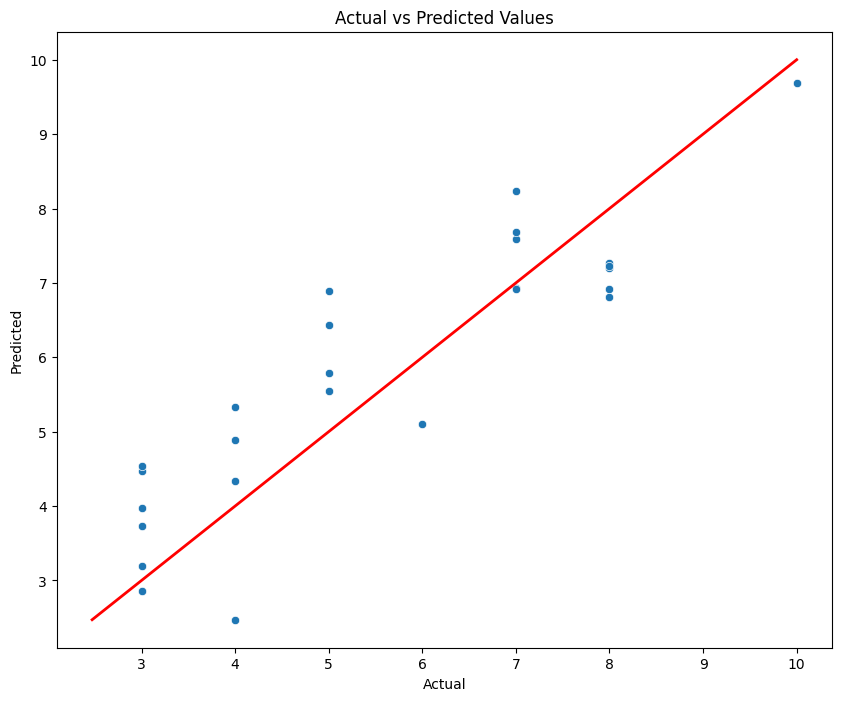

,meeting_number,normalized_speech_frequency,gini_coefficient,degree_centrality,num_speakers,normalized_interaction_frequency,speaker_id,Actual,Predicted
0,16,3982.025316,0.177971,0.184716,5,7.215190,3,10.0,9.693709
1,1,652.436975,0.401351,0.098437,5,0.504202,0,4.0,2.472192
2,14,3953.454545,0.415748,0.124639,5,14.181818,3,7.0,8.239514
3,5,183.243243,0.420915,0.007840,5,0.000000,2,4.0,4.340686
4,3,415.789474,0.288193,0.017212,5,2.105263,2,3.0,3.975451
5,17,200.232558,0.309514,0.009210,5,0.000000,2,8.0,6.808845
6,3,1063.684211,0.288193,0.102913,5,1.578947,0,3.0,4.466299
7,4,4254.000000,0.752303,0.110618,5,685.500000,3,5.0,6.886455
8,1,289.411765,0.401351,0.020269,5,0.504202,4,3.0,2.851921
9,14,239.454545,0.415748,0.001786,5,0.545455,1,5.0,5.794955


In [10]:
def predict_and_evaluate(best_reg_model_info, X_train, y_train, X_test, y_test):
    best_model = best_reg_model_info['model_object']
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    results_with_test_df = pd.concat(
        [X_test.reset_index(drop=True), results_df.reset_index(drop=True)], axis=1)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='Actual', y='Predicted', data=results_df)
    plt.plot([results_df.min().min(), results_df.max().max()], [
             results_df.min().min(), results_df.max().max()], color='red', linewidth=2)
    plt.title('Actual vs Predicted Values')
    plt.savefig('actual_vs_predicted.png')
    plt.show()

    return results_with_test_df


# Usage example:
results_df = predict_and_evaluate(
    best_reg_model_info, X_train, y_train, X_test, y_test)
display(results_df)

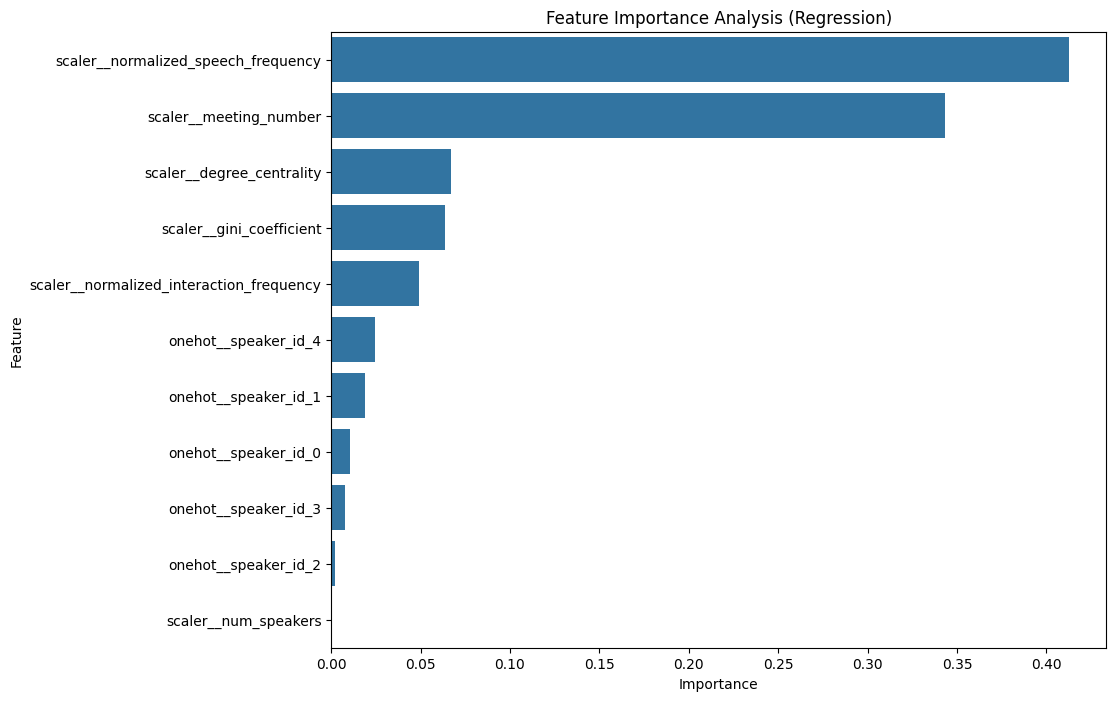

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = pd.DataFrame(column_transformer.fit_transform(
    features), columns=column_transformer.get_feature_names_out())
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [round(variance_inflation_factor(
    X_vif.values, i), 2) for i in range(X_vif.shape[1])]
# Feature Importance
if hasattr(best_reg_model_info['model_object'].named_steps['model'], 'feature_importances_'):
    best_model = best_reg_model_info['model_object'].named_steps['model']
    feature_importances_reg = best_model.feature_importances_
    importance_df_reg = pd.DataFrame(
        {'Feature': column_transformer.get_feature_names_out(), 'Importance': feature_importances_reg})
    importance_df_reg = importance_df_reg.sort_values(
        by='Importance', ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df_reg)
    plt.title('Feature Importance Analysis (Regression)')
    plt.savefig('feature_importance.png')
    plt.show()
# Model Performance Table
model_performance_df = pd.DataFrame(model_performance)

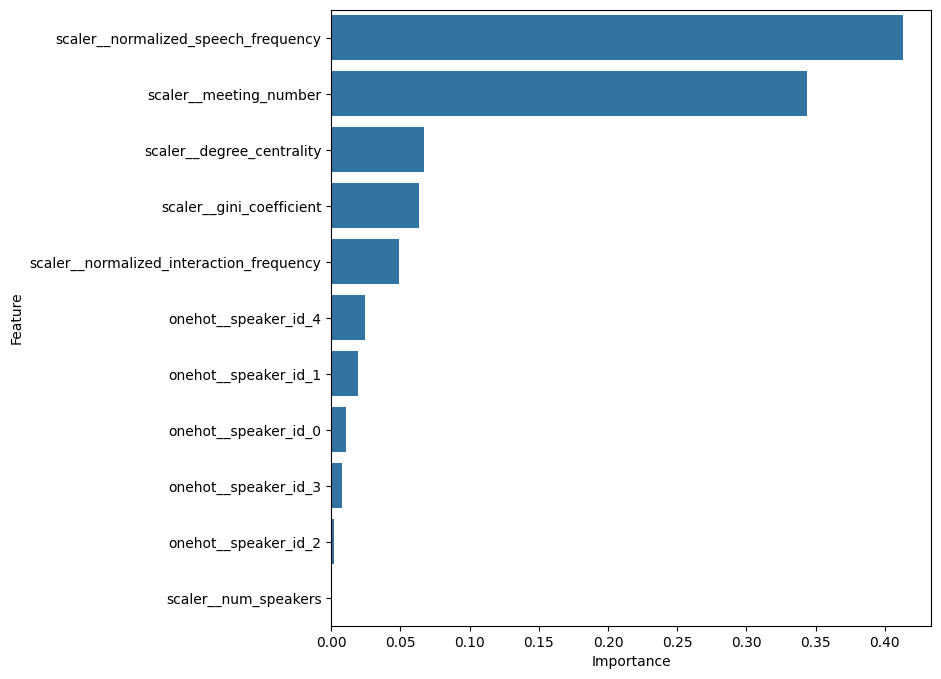

,Feature,VIF
0,scaler__meeting_number,1.40
1,scaler__normalized_speech_frequency,22.39
2,scaler__gini_coefficient,1.61
3,scaler__degree_centrality,3.77
4,scaler__num_speakers,1.49
5,scaler__normalized_interaction_frequency,1.60
6,onehot__speaker_id_0,1.33
7,onehot__speaker_id_1,2.01
8,onehot__speaker_id_2,2.87
9,onehot__speaker_id_3,16.33


In [13]:
X_vif = pd.DataFrame(column_transformer.fit_transform(
    features), columns=column_transformer.get_feature_names_out())
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [round(variance_inflation_factor(
    X_vif.values, i), 2) for i in range(X_vif.shape[1])]
# Feature Importance
if hasattr(best_reg_model_info['model_object'].named_steps['model'], 'feature_importances_'):
    best_model = best_reg_model_info['model_object'].named_steps['model']
    feature_importances_reg = best_model.feature_importances_
    importance_df_reg = pd.DataFrame(
        {'Feature': column_transformer.get_feature_names_out(), 'Importance': feature_importances_reg})
    importance_df_reg = importance_df_reg.sort_values(
        by='Importance', ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df_reg)
    plt.subplots_adjust(left=0.3)
    plt.savefig('feature_importance.png')
    plt.show()
# Model Performance Table
model_performance_df = pd.DataFrame(model_performance)
# Hyperparameter details
hyperparameter_details = [
    {'Model': 'Decision Tree', 'Parameters': 'max_depth: [3, 5, 7]'},
    {'Model': 'Random Forest Regressor',
        'Parameters': 'n_estimators: [50, 100, 150], max_depth: [5, 10, 15]'},
    {'Model': 'XGBRegressor',
        'Parameters': 'n_estimators: [50, 100], max_depth: [3, 5, 7], learning_rate: [0.01, 0.1, 0.2]'},
    {'Model': 'Gradient Boosting Regressor',
        'Parameters': 'n_estimators: [50, 100], max_depth: [3, 5], learning_rate: [0.01, 0.1, 0.2, 0.5]'},
    {'Model': 'K-Nearest Neighbors Regressor',
        'Parameters': 'n_neighbors: [3, 5, 7]'},
    {'Model': 'LightGBM Regressor',
        'Parameters': 'n_estimators: [50, 100, 200], num_leaves: [31, 62], learning_rate: [0.01, 0.1, 0.3]'},
    {'Model': 'CatBoost Regressor',
        'Parameters': 'iterations: [100, 200, 400], depth: [4, 6, 10]'},
    {'Model': 'SVM Regressor',
        'Parameters': 'C: [0.1, 1, 10], kernel: [linear, rbf]'}
]
hyperparameter_df = pd.DataFrame(hyperparameter_details)
vif_data